# Fully connected NN on bottleneck features
Concatenate all preprocessed features from Inception, Xception, and InceptionResNet.

Then train a fully connected NN with 1 hidden layer, last layer with softmax.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import _pickle as pickle
from os import listdir
from os.path import join, isfile

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l1, l2, l1_l2

Using TensorFlow backend.


In [2]:
NUM_CLASSES = 120
SEED = 1993
np.random.seed(seed=SEED)
data_dir = '../data'

labels = pd.read_csv(join(data_dir, 'labels.csv'))
print('Number of all train images: {}'.format(len(labels)))
print("Train data has {} classes.".format(len(labels.groupby('breed').count())))
assert len(labels.groupby('breed').count()) == NUM_CLASSES, 'Number of classes in training set is not 120!'

sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print('Number of all test images: {}'.format(len(sample_submission)))

# Split to train and validation sets
l_val = labels.groupby('breed').apply(pd.DataFrame.sample, frac=0.2).reset_index(drop=True)
l_tr = labels.loc[~labels['id'].isin(l_val['id'])]
l_tr_index = {label:i for i,label in enumerate(np.unique(l_tr.breed))}
l_tr_temp = [l_tr_index[label] for label in l_tr.breed]
l_val_temp = [l_tr_index[label] for label in l_val.breed]
y_tr = to_categorical(l_tr_temp ,num_classes=120)
y_val = to_categorical(l_val_temp ,num_classes=120)
print('y_tr shape: {}'.format(y_tr.shape))
print('y_val shape: {}'.format(y_val.shape))

Number of all train images: 10222
Train data has 120 classes.
Number of all test images: 10357
y_tr shape: (8185, 120)
y_val shape: (2037, 120)


In [6]:
filename = data_dir + '//train//xs_bf_inception_v3'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_inception = pickle.load(fp)
print('xs_bf_inception shape: {} size: {:,}'.format(xs_bf_inception.shape, xs_bf_inception.size))

filename = data_dir + '//train//xs_bf_xception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_xception = pickle.load(fp)
print('xs_bf_xception shape: {} size: {:,}'.format(xs_bf_xception.shape, xs_bf_xception.size))

filename = data_dir + '//train//xs_bf_irn'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_irn = pickle.load(fp)
print('xs_bf_irn shape: {} size: {:,}'.format(xs_bf_irn.shape, xs_bf_irn.size))

N_FEATURES = xs_bf_inception.shape[1] + xs_bf_xception.shape[1] + xs_bf_irn.shape[1] - 3

xs_bf = pd.DataFrame(data=np.concatenate(
    (xs_bf_inception.as_matrix(columns=xs_bf_inception.columns[0:]),
     xs_bf_xception.as_matrix(columns=xs_bf_xception.columns[1:]),
     xs_bf_irn.as_matrix(columns=xs_bf_irn.columns[1:])),
     axis=1), columns=['id']+list(range(N_FEATURES)))
print('Concatenated features xs_bf shape: {} size: {:,}'.format(xs_bf.shape, xs_bf.size))

Loading from ../data//train//xs_bf_inception_v3
xs_bf_inception shape: (10222, 2049) size: 20,944,878
Loading from ../data//train//xs_bf_xception
xs_bf_xception shape: (10222, 2049) size: 20,944,878
Loading from ../data//train//xs_bf_irn
xs_bf_irn shape: (10222, 1537) size: 15,711,214
Concatenated features xs_bf shape: (10222, 5633) size: 57,580,526


In [5]:
# Split to train/val sets
x_tr = np.zeros((len(l_tr), xs_bf.shape[1]-1), dtype='float32')
for i, img_id in enumerate(l_tr['id']):
    x_tr[i] = xs_bf[xs_bf.id == img_id].values[0][1:]
print('Train bottleneck features shape: {} size: {:,}'.format(x_tr.shape, x_tr.size))

x_val = np.zeros((len(l_val), xs_bf.shape[1]-1), dtype='float32')
for i, img_id in enumerate(l_val['id']):
    x_val[i] = xs_bf[xs_bf.id == img_id].values[0][1:]
print('Validation bottleneck features shape: {} size: {:,}'.format(x_val.shape, x_val.size))

Train bottleneck features shape: (8185, 5632) size: 46,097,920
Validation bottleneck features shape: (2037, 5632) size: 11,472,384


In [10]:
# Setup model
model = Sequential()

model.add(Dense(200, input_shape=(N_FEATURES,), kernel_regularizer=l2(0.00001)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
    
model.add(Dense(120, activation='softmax', kernel_regularizer=l2(0.0000001)))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
# Train
history = model.fit(x_tr, y_tr,
              batch_size=1500,
              epochs=50,
              verbose=1,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

scores = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 8185 samples, validate on 2037 samples
Epoch 1/50
8185/8185 [==============================] - 1s 178us/step - loss: 4.2121 - acc: 0.1594 - val_loss: 2.6678 - val_acc: 0.7501
Epoch 2/50
8185/8185 [==============================] - 1s 84us/step - loss: 2.2545 - acc: 0.5840 - val_loss: 0.9988 - val_acc: 0.8753
Epoch 3/50
8185/8185 [==============================] - 1s 94us/step - loss: 1.0818 - acc: 0.7918 - val_loss: 0.4426 - val_acc: 0.9028
Epoch 4/50
8185/8185 [==============================] - 1s 82us/step - loss: 0.6432 - acc: 0.8487 - val_loss: 0.3289 - val_acc: 0.9141
Epoch 5/50
8185/8185 [==============================] - 1s 80us/step - loss: 0.4819 - acc: 0.8743 - val_loss: 0.3012 - val_acc: 0.9165
Epoch 6/50
8185/8185 [==============================] - 1s 76us/step - loss: 0.4113 - acc: 0.8922 - val_loss: 0.2835 - val_acc: 0.9195
Epoch 7/50
8185/8185 [==============================] - 1s 78us/step - loss: 0.3568 - acc: 0.9016 - val_loss: 0.2814 - val_acc: 0.9141
Epoch 

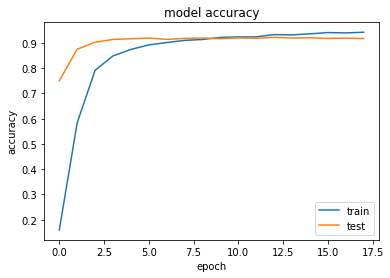

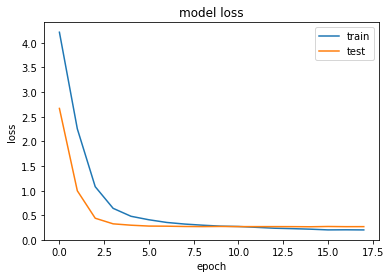

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
# Load test set data
filename = data_dir + '//test//xs_bf_inception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_inception = pickle.load(fp)
print('xs_bf_inception shape: {} size: {:,}'.format(xs_bf_inception.shape, xs_bf_inception.size))

filename = data_dir + '//test//xs_bf_xception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_xception = pickle.load(fp)
print('xs_bf_xception shape: {} size: {:,}'.format(xs_bf_xception.shape, xs_bf_xception.size))

filename = data_dir + '//test//xs_bf_irn'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_irn = pickle.load(fp)
print('xs_bf_irn shape: {} size: {:,}'.format(xs_bf_irn.shape, xs_bf_irn.size))

xs_test_bf = pd.DataFrame(data=np.concatenate(
    (xs_bf_inception.as_matrix(columns=xs_bf_inception.columns[0:]),
     xs_bf_xception.as_matrix(columns=xs_bf_xception.columns[1:]),
     xs_bf_irn.as_matrix(columns=xs_bf_irn.columns[1:])
    ), axis=1), columns=['id']+list(range(N_FEATURES)))
print('Concatenated features xs_bf shape: {} size: {:,}'.format(xs_test_bf.shape, xs_test_bf.size))

Loading from ../data//test//xs_bf_inception
xs_bf_inception shape: (10357, 2049) size: 21,221,493
Loading from ../data//test//xs_bf_xception
xs_bf_xception shape: (10357, 2049) size: 21,221,493
Loading from ../data//test//xs_bf_irn
xs_bf_irn shape: (10357, 1537) size: 15,918,709
Concatenated features xs_bf shape: (10357, 5633) size: 58,340,981


In [17]:
# Predict
ys_test = model.predict(xs_test_bf.as_matrix(columns=xs_test_bf.columns[1:]), batch_size=512, verbose=1)
print('Predicted ys_test shape: {} size: {:,}'.format(ys_test.shape, ys_test.size))

10357/10357 [==============================] - 9s 904us/step
Predicted ys_test shape: (10357, 120) size: 1,242,840


In [18]:
# Save submission
for i, breed in enumerate(sample_submission.columns[1:]):
    sample_submission[breed] = ys_test[:, l_tr_index[breed]]
    
sample_submission.to_csv('..//submissions//sub_bottleneck_nn_inc_xc_irn_l2.csv', index=None)